# Kinetic PET reconstruction - Biograph mMR
This notebook shows how to use occiput's PET_Dynamic_Scan class to load and reconstruct kinetic PET data acquired in listmode with the Siemens Biograph mMR PET-MR scanner. 

The notebook has the following layout: 

- Load acquisition data (prompts, randoms, sensitivity, scatter, attenuation)
- Reconstruct
 - 1) Reconstruction of time series of 2D slice - for quick inspection
 - 2) Fully 3D reconstruction of single time frame
 - 3) Fully 3D reconstruction of static image using data from all time frames 
 - 4) Fully 3D reconstruction of all time frames 

## Load data (prompts, randoms, sensitivity, scatter, attenuation) 

In [1]:
import occiput
from occiput.Reconstruction.PET import PET_Static_Scan, PET_Dynamic_Scan
from occiput.Reconstruction.PET.PET_scanners import Biograph_mMR

In [2]:
pet = PET_Dynamic_Scan()

In [3]:
pet.set_scanner(Biograph_mMR)

In [4]:
pet.use_compression(True)

In [5]:
# Display scan duration
from interfile import Interfile
header = Interfile.load('../data/PET_data/Kinetic/FDG_mMR/CLIM43L/MR/PET_ACQ_466_20141117103102-0.l.hdr')
print "The acquisition is",header['image duration']['value']/60.0,"min long"

The acquisition is 70.0 min long


In [6]:
# Define duration of each kinetic time-frame 
N_frames     = 24
duration_min = 70
time_bins = int32( (linspace(0,1,N_frames+1))**2 * duration_min*60.0*1000 ) 

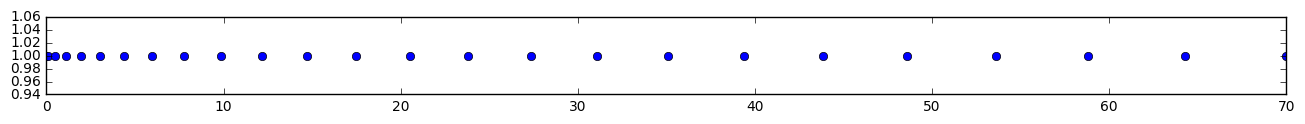

In [7]:
figure(figsize=[16,1])
plot( time_bins/1000/60.0, ones(time_bins.shape), 'o' )

In [8]:
pet.import_listmode('../data/PET_data/Kinetic/FDG_mMR/CLIM43L/MR/PET_ACQ_466_20141117103102-0.l.hdr',time_bins)

In [9]:
pet.import_sensitivity('../data/PET_data/scans/2014_09_05_brain_nf_014_base/listmode_and_sensitivity/norm3d_00.h33')

In [10]:
scatter_duration_ms = 90*60*1000
pet.import_scatter('../data/PET_data/scans/2014_09_05_brain_nf_014_base/scatter/brain_scatter3D.s.hdr',duration_ms=scatter_duration_ms)

In [11]:
pet.import_attenuation(filename='../data/PET_data/scans/2014_09_05_brain_nf_014_base/mumap_JSRecon/JSRecon-00-umap.v.hdr', 
                       filename_hardware='../data/PET_data/scans/2014_09_05_brain_nf_014_base/mumap_JSRecon/JSRecon-00-umap-hardware.v.hdr')

In [12]:
attenuation_projection = pet.project_attenuation(pet.static.attenuation)

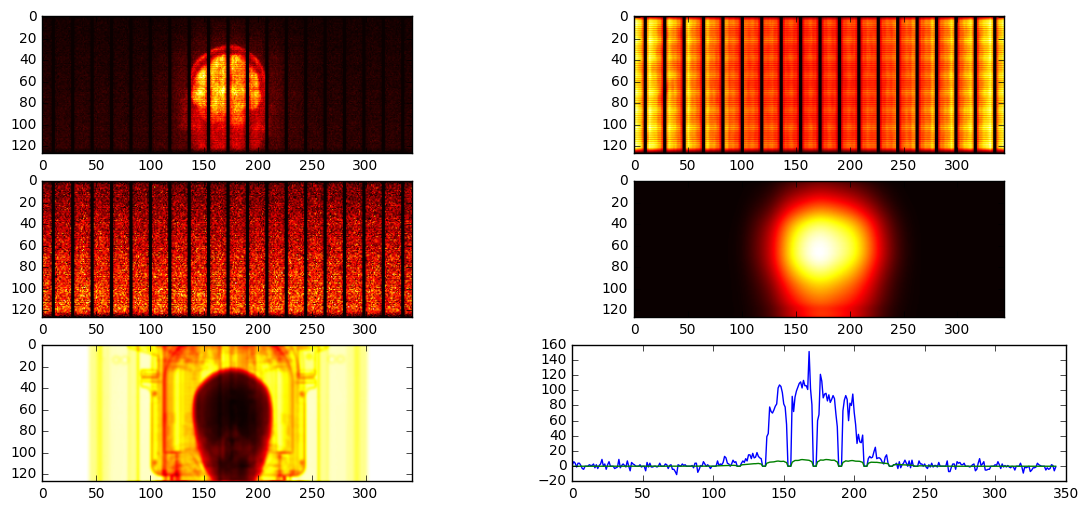

In [13]:
# Display data acquired during the entire acquisition
figure(figsize=[14,6])
subplot(3,2,1); imshow(flipud(pet.static.prompts.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,2); imshow(flipud(pet.static.sensitivity.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,3); imshow(flipud(pet.static.randoms.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,4); imshow(flipud(pet.static.scatter.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,5); imshow(flipud(attenuation_projection.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,6); pet.static.quick_inspect() 

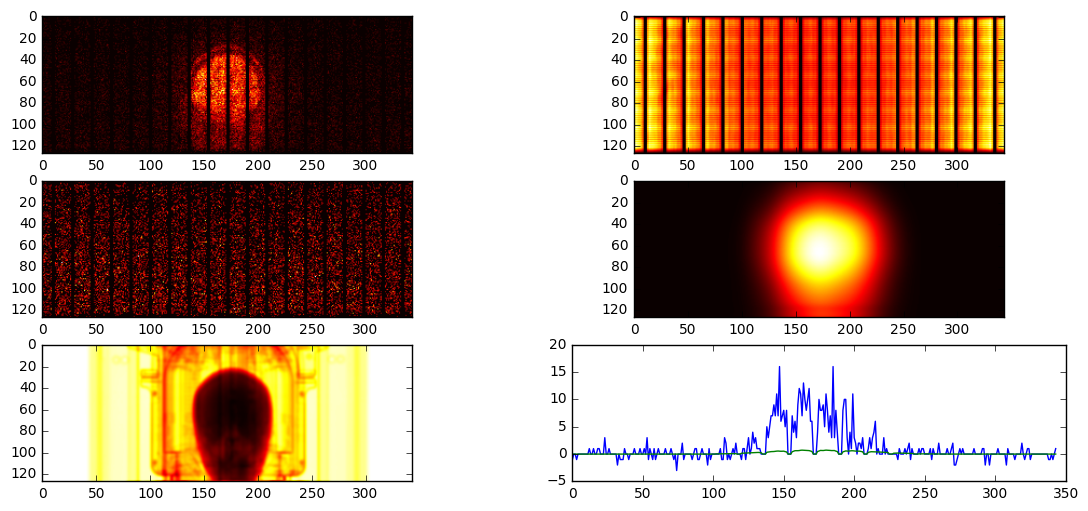

In [14]:
# Display data acquired during a single time frame
index = N_frames-1
figure(figsize=[14,6])
subplot(3,2,1); imshow(flipud(pet[index].prompts.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,2); imshow(flipud(pet[index].sensitivity.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,3); imshow(flipud(pet[index].randoms.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,4); imshow(flipud(pet[index].scatter.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,5); imshow(flipud(attenuation_projection.to_nd_array()[0,5,:,:].transpose()), cmap='hot')
subplot(3,2,6); pet[index].quick_inspect() 

- ### Use zoomed reconstruction and crop projection space to increase reconstruction speed

In [15]:
pet.set_activity_shape([128,128,128])
pet.set_activity_size([128*pet.activity_size[0]/344.0,128*pet.activity_size[1]/344.0,128*pet.activity_size[2]/127.0])

pet.brain_crop()

Cropping currently only works with uncompressed data. 


## Reconstruct

- ### 1) Reconstruction of time series of a thick 2D slice - for quick inspection of kinetics

In [16]:
pet2D = pet.get_2D_slices(slices=[60,61,62,63,64,65])

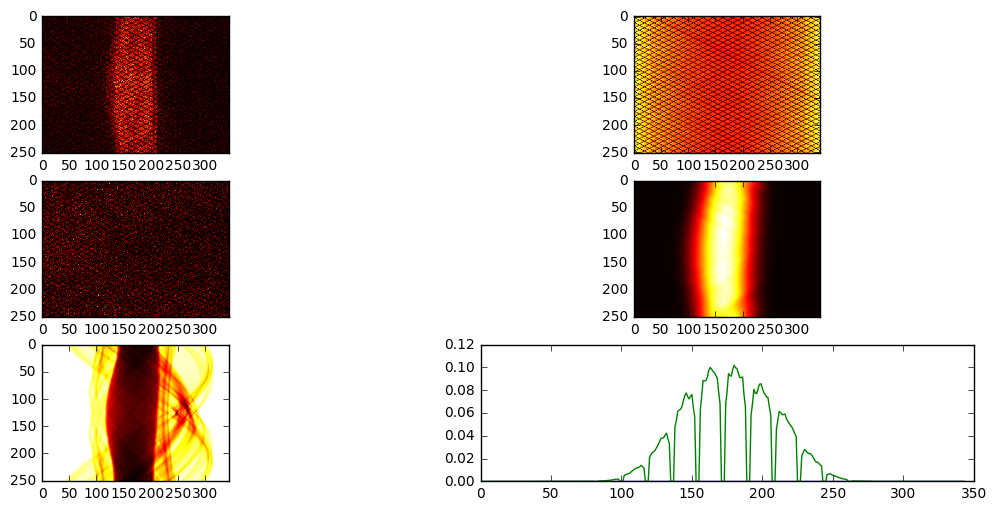

In [18]:
figure(figsize=[14,6])
subplot(3,2,1); imshow(pet2D.prompts.to_nd_array()[:,0,:,4],cmap="hot")
subplot(3,2,2); imshow(pet2D.sensitivity.to_nd_array()[:,0,:,4],cmap="hot")
subplot(3,2,3); imshow(pet2D.randoms.to_nd_array()[:,0,:,4],cmap="hot")
subplot(3,2,4); imshow(pet2D.scatter.to_nd_array()[:,0,:,4],cmap="hot")
subplot(3,2,5); imshow(pet2D.attenuation_projection.to_nd_array()[:,0,:,4],cmap="hot")
subplot(3,2,6); pet2D.quick_inspect(index_axial=0, index_slice=0)

In [19]:
activity2D = pet2D.osem_reconstruction(iterations=10, subset_mode="random", subset_size=64)
#activity2D = pet2D.mlem_reconstruction(iterations=10) 

0
1
2
3
4
5
6
7
8
9


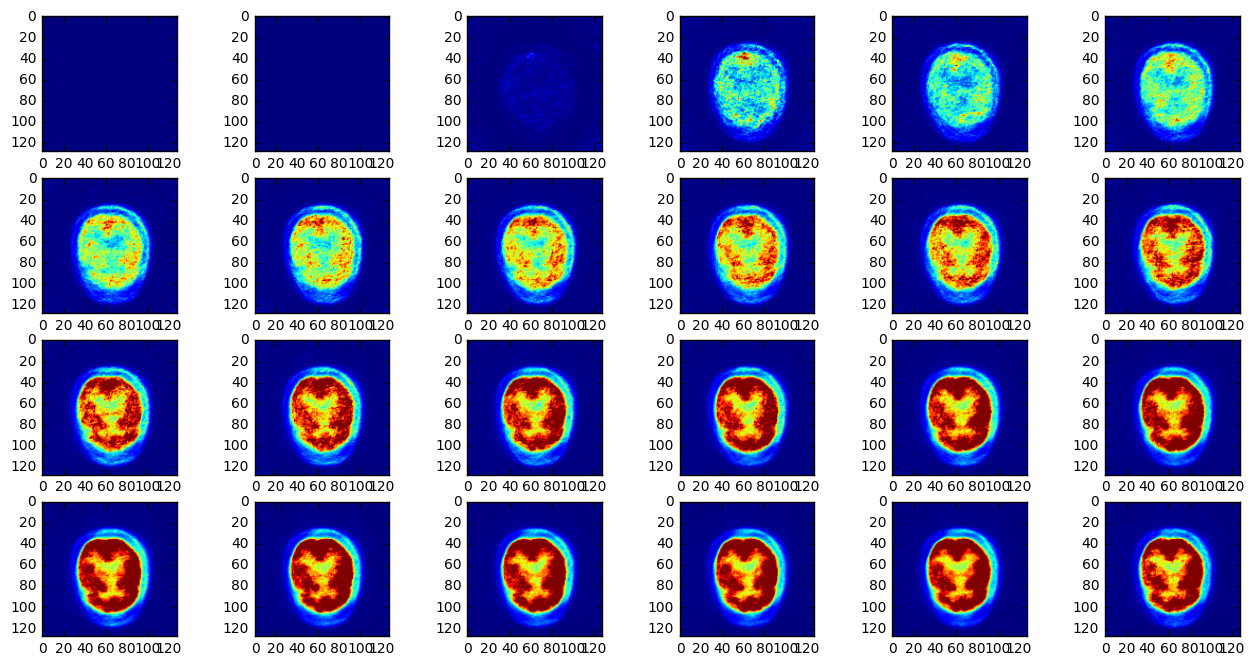

In [20]:
figure(figsize=[16,8]) 
N = N_frames 
for i in range(N): 
    if N_frames == 24:
        subplot(4,6,i+1); imshow(activity2D.data[:,:,activity2D.data.shape[2]-i-1], vmax=50.0) 
    else: 
        subplot(1,N,i+1); imshow(activity2D.data[:,:,activity2D.data.shape[2]-i-1], vmax=50.0) 

- ### 2) Fully 3D reconstruction of single time frame

In [21]:
activity0 = pet[3].osem_reconstruction(iterations=10, subset_mode="ordered_axial", subset_size=12)

0
1
2
3
4
5
6
7
8
9


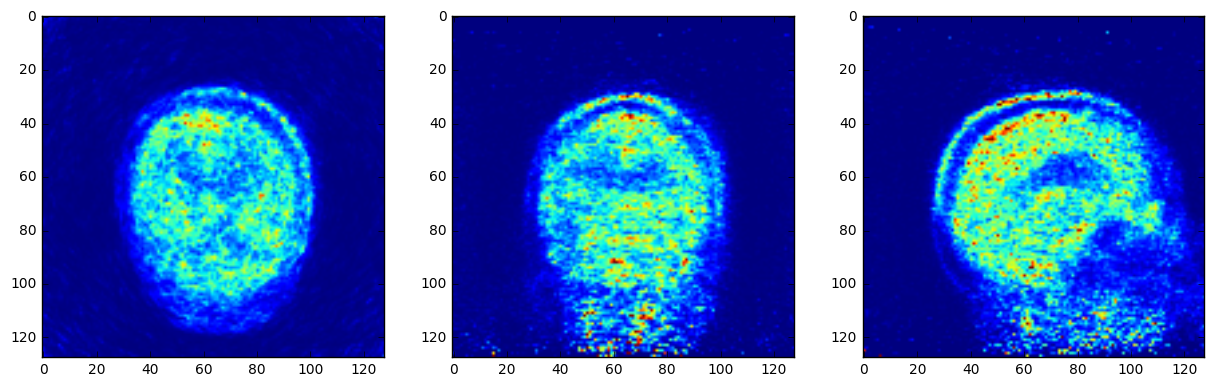

In [22]:
figure(figsize=[15,5])
subplot(1,3,1); imshow(activity0.data[:,:,64], vmax=10.0); 
subplot(1,3,2); imshow(activity0.data[64,:,:].T, vmax=10.0)
subplot(1,3,3); imshow(activity0.data[:,64,:].T, vmax=10.0)

- ### 3) Fully 3D reconstruction of static image using data from all time frames 

In [23]:
activity_static = pet.static.osem_reconstruction(iterations=10, subset_mode="ordered_axial", subset_size=12)

0
1
2
3
4
5
6
7
8
9


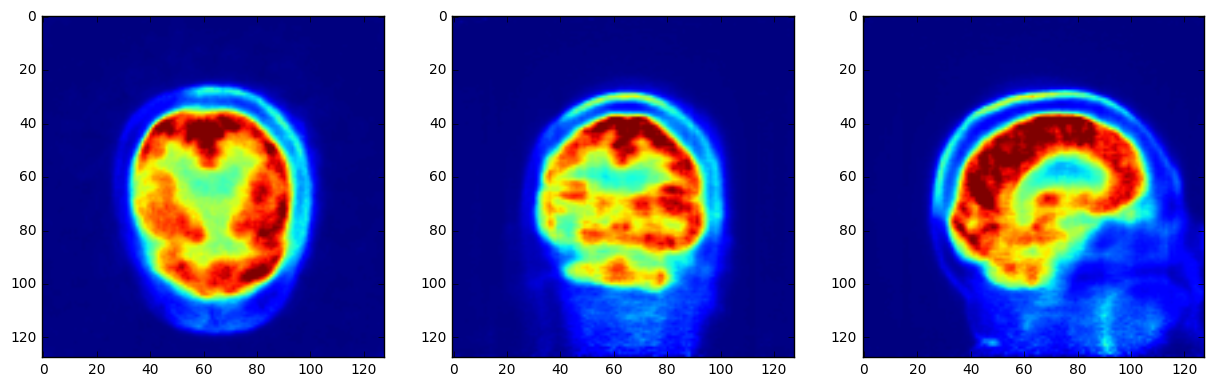

In [ ]:
figure(figsize=[15,5])
subplot(1,3,1); imshow(activity_static.data[:,:,64], vmax=10.0); 
subplot(1,3,2); imshow(activity_static.data[64,:,:].T, vmax=10.0)
subplot(1,3,3); imshow(activity_static.data[:,64,:].T, vmax=10.0)

- ### 4) Fully 3D reconstruction of all time frames

In [ ]:
pet.osem_reconstruction(iterations=5, subset_mode="ordered_axial", subset_size=12)

Reconstructing frame 0/24
0
1
2
3
4
Reconstructing frame 1/24
0
1
2
3
4
Reconstructing frame 2/24
0
1
2
3
4
Reconstructing frame 3/24
0
1
2
3
4
Reconstructing frame 4/24
0
1
2
3
4
Reconstructing frame 5/24
0
1
2
3
4
Reconstructing frame 6/24
0
1
2
3
4
Reconstructing frame 7/24
0
1
2
3
4
Reconstructing frame 8/24
0
1
2
3
4
Reconstructing frame 9/24
0
1
2
3
4
Reconstructing frame 10/24
0
1
2
3
4
Reconstructing frame 11/24
0
1
2
3
4
Reconstructing frame 12/24
0
1
2
3
4
Reconstructing frame 13/24
0
1
2
3
4
Reconstructing frame 14/24
0
1
2
3
4
Reconstructing frame 15/24
0
1
2
3
4
Reconstructing frame 16/24
0
1
2
3
4
Reconstructing frame 17/24
0
1
2
3
4
Reconstructing frame 18/24
0
1
2
3
4
Reconstructing frame 19/24
0
1
2
3
4
Reconstructing frame 20/24
0
1
2
3
4
Reconstructing frame 21/24
0
1
2
3
4
Reconstructing frame 22/24
0


In [ ]:
N = N_frames 
for i in range(N): 
    activity = pet[i].activity
    if N_frames == 24:
        subplot(4,6,i+1); imshow(activity.data[:,64,:].T, vmax=10.0)
    else: 
        subplot(1,N,i+1); imshow(activity.data[:,64,:].T, vmax=10.0)

In [ ]:
a = pet.get_activity_as_array()

In [ ]:
plot(a[:,64,50,50])

- ### 5) Fully 3D direct reconstruction